## Import statements

In [132]:
import meep as mp
import math
import cmath
import argparse
import numpy as np
from IPython.display import Video
import matplotlib.pyplot as plt
from IPython.display import Image
from scipy.interpolate import interp1d

## Define materials

In [5]:
# epsilon from supplementary material of ilic et al for lambda = 610 nm, values confirmed on the site https://refractiveindex.info/

n_SiO2 = 1.46
n_Al2O3 = 1.68
n_Ta2O5 = 2.09
n_TiO2 = 2.35
SiO2 = mp.Medium(epsilon=n_SiO2**2)
Al2O3 = mp.Medium(epsilon=n_Al2O3**2)
Ta2O5 = mp.Medium(epsilon=n_Ta2O5**2)
TiO2 = mp.Medium(epsilon=n_TiO2**2)

## Set up quarter-wave (qw) stack parameters

In [6]:
# design qw stack to block wavelength of lambda_0 microns
lambda_0 = 1.2
fcen_0 = 1/lambda_0
print('Center frequency', fcen_0)

# set up qw stack
n_layers = 10
n1 = n_SiO2
n2 = n_TiO2
material1 = SiO2
material2 = TiO2
a = (n1+n2)/(4*n1*n2*fcen_0)
d1 = a*n2/(n1+n2)
d2 = a*n1/(n1+n2)

# Compute qw stack delta f
delta_f = fcen_0*(4/np.pi)*np.arcsin(np.abs(n1-n2)/(n1+n2))
print('Quarter wave gap size', delta_f)

Center frequency 0.8333333333333334
Quarter wave gap size 0.25016415689653043


## Spectral reflectance and transmittance at normal incidence for quarter-wave stack of SiO2 and TiO2 

-----------
Initializing structure...
time for choose_chunkdivision = 0.000298977 s
Working in 2D dimensions.
Computational cell is 15.325 x 9 x 0 with resolution 40
time for set_epsilon = 0.224069 s
-----------


<AxesSubplot:xlabel='X', ylabel='Y'>

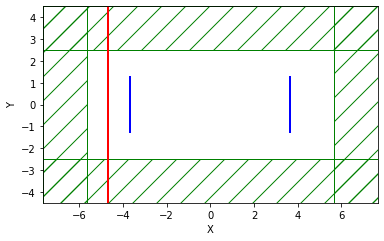

In [4]:
# Set up simulation for first run: no qw stack

resolution = 40     # pixels/um

# set pml
dpml = 2.
pml_layers = [mp.PML(dpml)]

# pad up structure and make cell
pad = 4.
y_length = 5.
sx = n_layers*a + 2*dpml + 2*pad
sy = y_length + 2*dpml
cell = mp.Vector3(sx,sy)

# make geometry, no qw stack
geometry = []


# make a line of sources corresponding to normal incidence
# send in light centered at 610 nm wavelgnth
lambda_cen = 0.61
fcen = 1/lambda_cen
df = 0.1
src_pos = -0.5*sx + dpml + pad/4
sources = [ mp.Source(mp.GaussianSource(fcen, fwidth=df, is_integrated=True),
                      # need is_integrated=True because source extends through pml
                      component=mp.Ez, 
                      center=mp.Vector3(src_pos,0),
                      size=mp.Vector3(0, sy)) ]

# make simulation object
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution,
                    k_point=mp.Vector3())

# set up fluxes for reflected and transmitted flux
nfreq = 100
refl_pos = -0.5*sx + dpml + pad/2
refl_fr = mp.FluxRegion(center=mp.Vector3(refl_pos,0), size=mp.Vector3(0, y_length/2))
refl = sim.add_flux(fcen, df, nfreq, refl_fr)
tran_pos = 0.5*sx - dpml - pad/2
tran_fr = mp.FluxRegion(center=mp.Vector3(tran_pos,0), size=mp.Vector3(0,y_length/2,0))
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

# Plot
sim.plot2D()

In [5]:
# Normalization run

pt = mp.Vector3(0.5*sx-dpml-pad/4, 0)
sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez, pt, 1e-6))
norm_refl_data = sim.get_flux_data(refl)
norm_tran_flux = mp.get_fluxes(tran)

on time step 3118 (time=38.975), 0.00128295 s/step
field decay(t = 50.0125): 0.09987548842241936 / 0.09987548842241936 = 1.0
on time step 6198 (time=77.475), 0.00129882 s/step
field decay(t = 100.025): 0.2460356599098966 / 0.2460356599098966 = 1.0
on time step 9220 (time=115.25), 0.00132363 s/step
field decay(t = 150.0375): 1.4238074362198705e-08 / 0.2460356599098966 = 5.786996229494938e-08
run 0 finished at t = 150.0375 (12003 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 0.000375032 s
Working in 2D dimensions.
Computational cell is 15.325 x 9 x 0 with resolution 40
     block, center = (-1.56296,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-1.22982,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.896677,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.563538,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.230399,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,

<AxesSubplot:xlabel='X', ylabel='Y'>

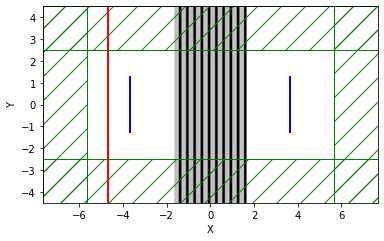

In [6]:
# Set up second simulation, with quarter-wave stack

sim.reset_meep()

geometry = [mp.Block(mp.Vector3(d1, mp.inf),
                     center=mp.Vector3(d1/2 + i*a, 0),
                     material=material1) for i in range(-n_layers//2, n_layers//2)] + \
            [mp.Block(mp.Vector3(d2, mp.inf),
                     center=mp.Vector3(d1 + d2/2 + i*a, 0),
                     material=material2) for i in range(-n_layers//2, n_layers//2)]

sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution,
                    k_point=mp.Vector3())

# Make new fluxes
refl = sim.add_flux(fcen, df, nfreq, refl_fr)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

# Load negated fields from normalization run
sim.load_minus_flux_data(refl, norm_refl_data)

# plot
sim.plot2D()

In [7]:
# Second run

pt = mp.Vector3(0.5*sx-dpml-pad/4, 0)
sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez, pt, 1e-6))
qw_refl_flux = mp.get_fluxes(refl)
qw_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(refl)

on time step 2996 (time=37.45), 0.00133525 s/step
field decay(t = 50.0125): 0.028789998691846633 / 0.028789998691846633 = 1.0
on time step 6026 (time=75.325), 0.00132051 s/step
field decay(t = 100.025): 0.10457806760557067 / 0.10457806760557067 = 1.0
on time step 9046 (time=113.075), 0.00132462 s/step
field decay(t = 150.0375): 6.246886539128096e-09 / 0.10457806760557067 = 5.973419362355225e-08
run 0 finished at t = 150.0375 (12003 timesteps)


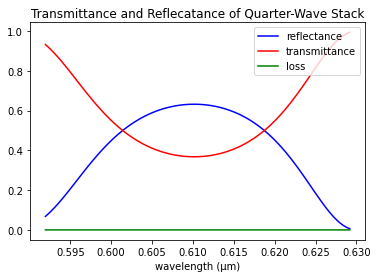

In [8]:
wl = []
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1/flux_freqs[i])
    Rs = np.append(Rs,-qw_refl_flux[i]/norm_tran_flux[i])
    Ts = np.append(Ts,qw_tran_flux[i]/norm_tran_flux[i])    
plt.figure()
plt.plot(wl,Rs,'b',label='reflectance')
plt.plot(wl,Ts,'r',label='transmittance')
plt.plot(wl,1-Rs-Ts,'g',label='loss')
plt.title('Transmittance and Reflecatance of Quarter-Wave Stack')
plt.xlabel("wavelength (μm)")
plt.legend(loc="upper right")
plt.show()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000368118 s
Working in 2D dimensions.
Computational cell is 15.325 x 9 x 0 with resolution 40
     block, center = (-1.56296,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-1.22982,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.896677,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.563538,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.230399,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,

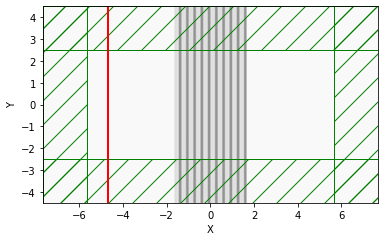

In [9]:
# Make Animation

animate = mp.Animate2D(sim, fields=mp.Ez, normalize=True)
sim.reset_meep()
sim.run(mp.at_every(1,animate),until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez, pt, 1e-6))

In [10]:
# Play animation

filename = "qw_stack.mp4"
fps = 10
animate.to_mp4(fps,filename)
Video(filename)

Generating MP4...


## Oblique incidence spectral reflectance and transmittance of quarter-wave stack

### in 2 dimensions

In [11]:
# Define source at an angle

# send in light centered at 610 nm wavelgnth
lambda_cen = 0.61
fcen = 1/lambda_cen
df = 0.1
src_pos = -0.5*sx + dpml #+ pad/4
src_pt = mp.Vector3(src_pos, 0)

# Set theta incidence, compute k and the amplitude function
theta_in = np.pi/6
n0 = 1. # air
k = mp.Vector3(fcen*n0).rotate(mp.Vector3(z=1), theta_in)
def pw_amp(k,x0):
    def _pw_amp(x):
        return cmath.exp(1j*2*math.pi*k.dot(x+x0))
    return _pw_amp

sources = [ mp.Source(mp.GaussianSource(fcen, fwidth=df, is_integrated=True),
                      # need is_integrated=True because source extends through pml
                      component=mp.Ez, 
                      center=mp.Vector3(src_pos,0),
                      size=mp.Vector3(0, sy), 
                      amp_func=pw_amp(k,src_pt)) ]

In [12]:
k

Vector3<1.4197137766958012, 0.8196721311475409, 0.0>

-----------
Initializing structure...
time for choose_chunkdivision = 6.41346e-05 s
Working in 2D dimensions.
Computational cell is 15.325 x 9 x 0 with resolution 40
time for set_epsilon = 0.224158 s
-----------
Meep: using complex fields.


<AxesSubplot:xlabel='X', ylabel='Y'>

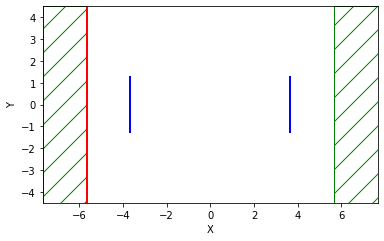

In [13]:
# Set up simulation for first run: no qw stack

resolution = 40     # pixels/um

# set pml
dpml = 2.
pml_layers = [mp.PML(dpml, direction=mp.X)]

# pad up structure and make cell
pad = 4.
y_length = 5.
sx = n_layers*a + 2*dpml + 2*pad
sy = y_length + 2*dpml
cell = mp.Vector3(sx,sy)

# make geometry, no qw stack
geometry = []




# make simulation object
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution,
                    k_point=k)

# set up fluxes for reflected and transmitted flux
nfreq = 100
refl_pos = -0.5*sx + dpml + pad/2
refl_fr = mp.FluxRegion(center=mp.Vector3(refl_pos,0), size=mp.Vector3(0, y_length/2))
refl = sim.add_flux(fcen, df, nfreq, refl_fr)
tran_pos = 0.5*sx - dpml - pad/2
tran_fr = mp.FluxRegion(center=mp.Vector3(tran_pos,0), size=mp.Vector3(0,y_length/2,0))
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

# Plot
sim.plot2D()

In [8]:
# Normalization run

pt = mp.Vector3(0.5*sx-dpml-pad/4, 0)
sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez, pt, 1e-6))
norm_refl_data = sim.get_flux_data(refl)
norm_tran_flux = mp.get_fluxes(tran)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000169992 s
Working in 2D dimensions.
Computational cell is 15.325 x 0.025 x 0 with resolution 40
time for set_epsilon = 0.00285006 s
-----------
field decay(t = 50.0125): 0.09987548842241933 / 0.09987548842241933 = 1.0
field decay(t = 100.025): 0.24603565990989693 / 0.24603565990989693 = 1.0
on time step 10404 (time=130.05), 0.000384471 s/step
field decay(t = 150.0375): 1.4238074362216814e-08 / 0.24603565990989693 = 5.786996229502291e-08
run 0 finished at t = 150.0375 (12003 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 9.58443e-05 s
Working in 2D dimensions.
Computational cell is 15.325 x 9 x 0 with resolution 40
     block, center = (-1.56296,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-1.22982,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.896677,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.563538,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.230399,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,

<AxesSubplot:xlabel='X', ylabel='Y'>

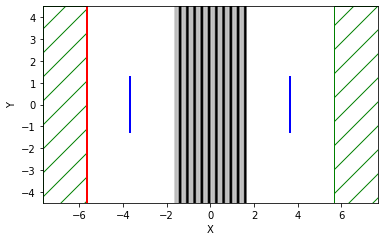

In [15]:
# Set up second simulation, with quarter-wave stack

sim.reset_meep()

geometry = [mp.Block(mp.Vector3(d1, mp.inf),
                     center=mp.Vector3(d1/2 + i*a, 0),
                     material=material1) for i in range(-n_layers//2, n_layers//2)] + \
            [mp.Block(mp.Vector3(d2, mp.inf),
                     center=mp.Vector3(d1 + d2/2 + i*a, 0),
                     material=material2) for i in range(-n_layers//2, n_layers//2)]

sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution,
                    k_point=k)

# Make new fluxes
refl = sim.add_flux(fcen, df, nfreq, refl_fr)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

# Load negated fields from normalization run
sim.load_minus_flux_data(refl, norm_refl_data)

# plot
sim.plot2D()

In [16]:
# Second run

pt = mp.Vector3(0.5*sx-dpml-pad/4, 0)
sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez, pt, 1e-6))
qw_refl_flux = mp.get_fluxes(refl)
qw_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(refl)

on time step 1905 (time=23.8125), 0.00209982 s/step
on time step 3795 (time=47.4375), 0.00211724 s/step
field decay(t = 50.0125): 0.027508371286845138 / 0.027508371286845138 = 1.0
on time step 5706 (time=71.325), 0.00209412 s/step
on time step 7614 (time=95.175), 0.00209719 s/step
field decay(t = 100.025): 0.2436239079920468 / 0.2436239079920468 = 1.0
on time step 9510 (time=118.875), 0.00211052 s/step
on time step 11426 (time=142.825), 0.00208785 s/step
field decay(t = 150.0375): 8.006017907890862e-05 / 0.2436239079920468 = 0.00032862201308059725
on time step 13322 (time=166.525), 0.00211041 s/step
on time step 15239 (time=190.488), 0.00208702 s/step
field decay(t = 200.05): 6.437617215787e-11 / 0.2436239079920468 = 2.642440665551247e-10
run 0 finished at t = 200.05 (16004 timesteps)


In [21]:
type(norm_tran_flux)

list

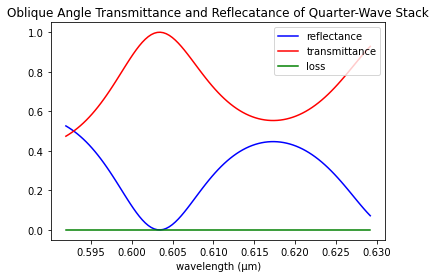

In [17]:
wl = []
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1/flux_freqs[i])
    Rs = np.append(Rs,-qw_refl_flux[i]/norm_tran_flux[i])
    Ts = np.append(Ts,qw_tran_flux[i]/norm_tran_flux[i])    
plt.figure()
plt.plot(wl,Rs,'b',label='reflectance')
plt.plot(wl,Ts,'r',label='transmittance')
plt.plot(wl,1-Rs-Ts,'g',label='loss')
plt.title('Oblique Angle Transmittance and Reflecatance of Quarter-Wave Stack')
plt.xlabel("wavelength (μm)")
plt.legend(loc="upper right")
plt.show()

-----------
Initializing structure...
time for choose_chunkdivision = 9.29832e-05 s
Working in 2D dimensions.
Computational cell is 15.325 x 9 x 0 with resolution 40
     block, center = (-1.56296,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-1.22982,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.896677,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.563538,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.230399,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,

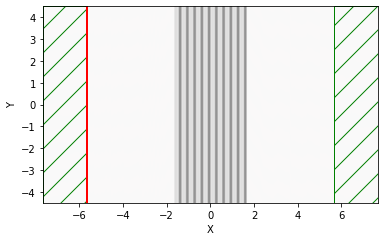

In [18]:
# Make Animation

animate = mp.Animate2D(sim, fields=mp.Ez, normalize=True)
sim.reset_meep()
sim.run(mp.at_every(1,animate),until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez, pt, 1e-6))

In [19]:
# Play Animation

filename = "qw_angle.mp4"
fps = 10
animate.to_mp4(fps,filename)
Video(filename)

Generating MP4...


### In 1-d

In [23]:
# Set up simulation for first run: no qw stack

resolution = 40     # pixels/um

# set pml
dpml = 2.
pml_layers = [mp.PML(dpml)]

# pad up structure and make cell
pad = 4.
y_length = 0.
sx = n_layers*a + 2*dpml + 2*pad
sy = y_length
cell = mp.Vector3(sx)

# make geometry, no qw stack
geometry = []


# make a line of sources corresponding to normal incidence
# send in light centered at 610 nm wavelgnth
lambda_cen = 0.61
fcen = 1/lambda_cen
df = 0.1
src_pos = -0.5*sx + dpml + pad/4

# Define source at an angle

# send in light centered at 610 nm wavelgnth
lambda_cen = 0.61
fcen = 1/lambda_cen
df = 0.1
src_pos = -0.5*sx + dpml #+ pad/4
src_pt = mp.Vector3(src_pos, 0)

# Set theta incidence, compute k and the amplitude function
theta_in = np.pi/6
n0 = 1. # air
k = mp.Vector3(fcen*n0).rotate(mp.Vector3(z=1), theta_in)
def pw_amp(k,x0):
    def _pw_amp(x):
        return cmath.exp(1j*2*math.pi*k.dot(x+x0))
    return _pw_amp

sources = [ mp.Source(mp.GaussianSource(fcen, fwidth=df, is_integrated=True),
                      # need is_integrated=True because source extends through pml
                      component=mp.Ez, 
                      center=mp.Vector3(src_pos,0),
                      size=mp.Vector3(0, sy), 
                      amp_func=pw_amp(k,src_pt)) ]

# make simulation object
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution,
                    k_point=k)

# set up fluxes for reflected and transmitted flux
nfreq = 100
refl_pos = -0.5*sx + dpml + pad/2
refl_fr = mp.FluxRegion(center=mp.Vector3(refl_pos,0), size=mp.Vector3(0, y_length/2))
refl = sim.add_flux(fcen, df, nfreq, refl_fr)
tran_pos = 0.5*sx - dpml - pad/2
tran_fr = mp.FluxRegion(center=mp.Vector3(tran_pos,0), size=mp.Vector3(0,y_length/2,0))
tran = sim.add_flux(fcen, df, nfreq, tran_fr)


In [24]:
# Normalization run

pt = mp.Vector3(0.5*sx-dpml-pad/4, 0)
sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez, pt, 1e-6))
norm_refl_data = sim.get_flux_data(refl)
norm_tran_flux = mp.get_fluxes(tran)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000130892 s
Working in 2D dimensions.
Computational cell is 15.325 x 0.025 x 0 with resolution 40
time for set_epsilon = 0.00251508 s
-----------
Meep: using complex fields.
field decay(t = 50.0125): 0.07955744600170675 / 0.07955744600170675 = 1.0
field decay(t = 100.025): 0.3331643631258137 / 0.3331643631258137 = 1.0
field decay(t = 150.0375): 1.7033054509464223e-07 / 0.3331643631258137 = 5.112507937420662e-07
run 0 finished at t = 150.0375 (12003 timesteps)


In [25]:
# Set up second simulation, with quarter-wave stack

sim.reset_meep()

geometry = [mp.Block(mp.Vector3(d1, mp.inf),
                     center=mp.Vector3(d1/2 + i*a, 0),
                     material=material1) for i in range(-n_layers//2, n_layers//2)] + \
            [mp.Block(mp.Vector3(d2, mp.inf),
                     center=mp.Vector3(d1 + d2/2 + i*a, 0),
                     material=material2) for i in range(-n_layers//2, n_layers//2)]

sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution,
                    k_point=k)

# Make new fluxes
refl = sim.add_flux(fcen, df, nfreq, refl_fr)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

# Load negated fields from normalization run
sim.load_minus_flux_data(refl, norm_refl_data)


-----------
Initializing structure...
time for choose_chunkdivision = 0.000197887 s
Working in 2D dimensions.
Computational cell is 15.325 x 0.025 x 0 with resolution 40
     block, center = (-1.56296,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-1.22982,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.896677,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.563538,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.230399,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (

In [26]:
# Second run

pt = mp.Vector3(0.5*sx-dpml-pad/4, 0)
sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez, pt, 1e-6))
qw_refl_flux = mp.get_fluxes(refl)
qw_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(refl)

field decay(t = 50.0125): 0.027508371286845048 / 0.027508371286845048 = 1.0
field decay(t = 100.025): 0.2436239079920467 / 0.2436239079920467 = 1.0
field decay(t = 150.0375): 8.0060179078913e-05 / 0.2436239079920467 = 0.00032862201308061535
field decay(t = 200.05): 6.437617215872894e-11 / 0.2436239079920467 = 2.6424406655865056e-10
run 0 finished at t = 200.05 (16004 timesteps)


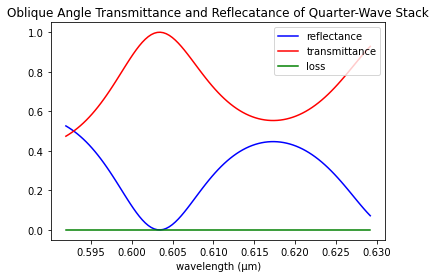

In [27]:
wl = []
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1/flux_freqs[i])
    Rs = np.append(Rs,-qw_refl_flux[i]/norm_tran_flux[i])
    Ts = np.append(Ts,qw_tran_flux[i]/norm_tran_flux[i])    
plt.figure()
plt.plot(wl,Rs,'b',label='reflectance')
plt.plot(wl,Ts,'r',label='transmittance')
plt.plot(wl,1-Rs-Ts,'g',label='loss')
plt.title('Oblique Angle Transmittance and Reflecatance of Quarter-Wave Stack')
plt.xlabel("wavelength (μm)")
plt.legend(loc="upper right")
plt.show()

## Reproduce figure 3 from Ilic et al: the reflectance heat map of the fabricated structure

### Visualize simulation setup

-----------
Initializing structure...
time for choose_chunkdivision = 0.0519772 s
Working in 2D dimensions.
Computational cell is 27.75 x 9 x 0 with resolution 40
     block, center = (-7.8635,0,0)
          size (0.018,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.3681,4.3681,4.3681)
     block, center = (-7.831,0,0)
          size (0.047,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-7.7295,0,0)
          size (0.156,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.3681,4.3681,4.3681)
     block, center = (-7.5455,0,0)
          size (0.212,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-7.3505,0,0)
          size (0.178,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          diele

<AxesSubplot:xlabel='X', ylabel='Y'>

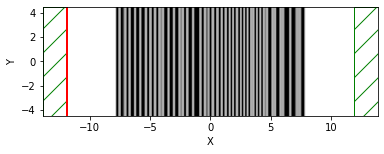

In [59]:
import meep as mp
import math
import cmath
import numpy as np
import matplotlib.pyplot as plt

##############################################
# Set materials and structure specifications #
##############################################

# indices of refraction at 610 nm from supplementary material of ilic et al
# values validated on the site https://refractiveindex.info/
# for now, assume dispersionless materials
# TODO: check how good of an assumption that is
# in future iterations, use the values on that site for dispersion relations

n_SiO2 = 1.46
n_Al2O3 = 1.68
n_Ta2O5 = 2.09
n_TiO2 = 2.35
SiO2 = mp.Medium(epsilon=n_SiO2**2)
Al2O3 = mp.Medium(epsilon=n_Al2O3**2)
Ta2O5 = mp.Medium(epsilon=n_Ta2O5**2)
TiO2 = mp.Medium(epsilon=n_TiO2**2)

# material specifications
n1 = Ta2O5
n2 = SiO2
D = [18,47,156,212,178,23,51,224,150,205,258,187,243,190,266,215,153,227,154,226,152,245,24,
     229,263,190,257,200,260,224,27,229,154,219,274,198,405,211,166,233,47,66,17,125,153,
     237,151,225,147,193,127,214,135,173,112,165,130,223,130,163,112,164,114,167,121,378,114,
     160,113,174,117,211,23,221,261,399,266,390,28,18,367,198,302,28,33,426,31,15,222,96]
for i in range(len(D)):
    D[i] /= 1000 # convert from nm specifications to um

######################
# Set up simulations #
######################

resolution = 40 # pixels/um

# send in light with wavelength from 450 nm to 2250 nm
wvl_min = 0.450
wvl_max = 2.250
frq_min = 1/wvl_max
frq_max = 1/wvl_min
fcen = (frq_min + frq_max)/2
df = frq_max - frq_min
nfreq = 100

# set pml
dpml = 2.
pml_layers = [mp.PML(dpml, direction=mp.X)]

# pad up structure and make the cell
pad = 4.
structure_length = sum(D)
y_length = 5.
sx = structure_length + 2*dpml + 2*pad
sy = y_length + 2*dpml
cell = mp.Vector3(sx,sy)

# make the geometry according to the specifications
geometry_no_stack = []
geometry_stack = [None]*len(D)
location_in_cell = -structure_length/2 
for i, element_width in enumerate(D):
    if i%2 == 0:
        material = Ta2O5
    else:
        material = SiO2
    geometry_stack[i] = mp.Block(mp.Vector3(element_width, mp.inf),
                                 center=mp.Vector3(location_in_cell + element_width/2, 0),
                                 material=material)
    location_in_cell += element_width

# set up the oblique-angle sources in parallel
src_pos = -0.5*sx + dpml
src_pt = mp.Vector3(src_pos, 0)
n_angles = 20
#n = mp.divide_parallel_processes(n_angles)
n = 10
n = n_angles - n
theta_in = n*np.pi/180
n0 = 1. # air
k = mp.Vector3(fcen*n0).rotate(mp.Vector3(z=1), theta_in)
def pw_amp(k,x0):
    def _pw_amp(x):
        return cmath.exp(1j*2*math.pi*k.dot(x+x0))
    return _pw_amp
sources = [ mp.Source(mp.GaussianSource(fcen, fwidth=df, is_integrated=True),
                      # need is_integrated=True because source extends through pml
                      component=mp.Ez, 
                      center=mp.Vector3(src_pos,0),
                      size=mp.Vector3(0, sy), 
                      amp_func=pw_amp(k,src_pt)) ]
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry_stack,
                    sources=sources,
                    resolution=resolution,
                    k_point=k)
sim.plot2D()

### Visualize results

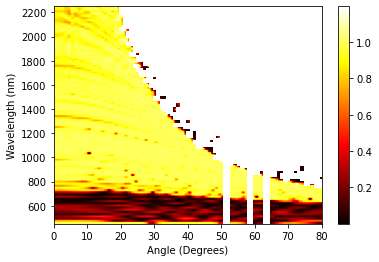

In [203]:
reflectances_all = []
for i in range(80):
    try:
        with open('./angle_by_angle_compute/fabricated_structure_reflectance_one_angle_' 
                  + str(i) + '.npy', 'rb') as f:
            wavelengths = np.load(f)
            reflectances = np.load(f)
        reflectances_all.append(reflectances)
    except:
        reflectances_all.append(None)
for i in range(80):
    if reflectances_all[i] is None:
        
        if reflectances_all[i+1] is not None:
            reflectances_all[i] = (reflectances_all[i-1] + reflectances_all[i+1])/2
        else:
            reflectances_all[i] = reflectances_all[i-1]
        reflectances_all[i] = -1*np.ones(100)
reflectances_all = np.stack(reflectances_all)
lower_bound = 0
upper_bound = 1.2
reflectances_all = np.ma.masked_where((lower_bound > reflectances_all) | 
                                      (upper_bound < reflectances_all), reflectances_all)
plt.imshow(np.flip(reflectances_all, axis=1).T, cmap='hot', extent=[0,80,450,2250], aspect='auto')
plt.xlabel('Angle (Degrees)')
plt.ylabel('Wavelength (nm)')
plt.colorbar()

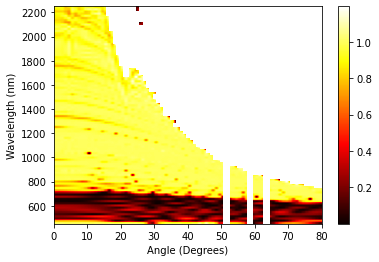

In [204]:
reflectances_all = []
for i in range(80):
    try:
        with open('./angle_by_angle_compute/back_fabricated_structure_reflectance_one_angle_' 
                  + str(i) + '.npy', 'rb') as f:
            wavelengths = np.load(f)
            reflectances = np.load(f)
        reflectances_all.append(reflectances)
    except:
        reflectances_all.append(None)
for i in range(80):
    if reflectances_all[i] is None:
        
        if i+1 < 80 and reflectances_all[i+1] is not None:
            reflectances_all[i] = (reflectances_all[i-1] + reflectances_all[i+1])/2
        else:
            reflectances_all[i] = reflectances_all[i-1]
        reflectances_all[i] = -1*np.ones(100)
reflectances_all = np.stack(reflectances_all)
lower_bound = 0
upper_bound = 1.2
reflectances_all = np.ma.masked_where((lower_bound > reflectances_all) | 
                                      (upper_bound < reflectances_all), reflectances_all)
plt.imshow(np.flip(reflectances_all, axis=1).T, cmap='hot', extent=[0,80,450,2250], aspect='auto')
plt.xlabel('Angle (Degrees)')
plt.ylabel('Wavelength (nm)')
plt.colorbar()

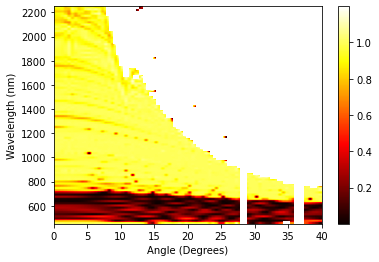

In [205]:
reflectances_all = []
for i in range(80):
    try:
        with open('./angle_by_angle_compute/back_fabricated_structure_reflectance_one_angle_doubled_pml_' 
                  + str(i) + '.npy', 'rb') as f:
            wavelengths = np.load(f)
            reflectances = np.load(f)
        reflectances_all.append(reflectances)
    except:
        reflectances_all.append(None)
for i in range(80):
    if reflectances_all[i] is None:
        
        if i+1 < 80 and reflectances_all[i+1] is not None:
            reflectances_all[i] = (reflectances_all[i-1] + reflectances_all[i+1])/2
        else:
            reflectances_all[i] = reflectances_all[i-1]
        reflectances_all[i] = -1*np.ones(100)
reflectances_all = np.stack(reflectances_all)
lower_bound = 0
upper_bound = 1.2
reflectances_all = np.ma.masked_where((lower_bound > reflectances_all) | 
                                      (upper_bound < reflectances_all), reflectances_all)
plt.imshow(np.flip(reflectances_all, axis=1).T, cmap='hot', extent=[0,40,450,2250], aspect='auto')
plt.xlabel('Angle (Degrees)')
plt.ylabel('Wavelength (nm)')
plt.colorbar()

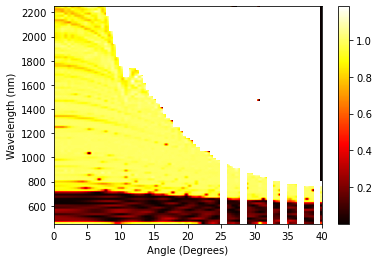

In [206]:
reflectances_all = []
for i in range(80):
    try:
        with open('./angle_by_angle_compute/back_fabricated_structure_reflectance_one_angle_doubled_pml_and_res_' 
                  + str(i) + '.npy', 'rb') as f:
            wavelengths = np.load(f)
            reflectances = np.load(f)
            stack_refl_flux = np.load(f)
            norm_tran_flux = np.load(f)
        reflectances_all.append(reflectances)
    except:
        reflectances_all.append(None)
for i in range(80):
    if reflectances_all[i] is None:
        
        if i+1 < 80 and reflectances_all[i+1] is not None:
            reflectances_all[i] = (reflectances_all[i-1] + reflectances_all[i+1])/2
        else:
            reflectances_all[i] = reflectances_all[i-1]
        reflectances_all[i] = -1*np.ones(100)
reflectances_all = np.stack(reflectances_all)
lower_bound = 0
upper_bound = 1.2
reflectances_all = np.ma.masked_where((lower_bound > reflectances_all) | 
                                      (upper_bound < reflectances_all), reflectances_all)
plt.imshow(np.flip(reflectances_all, axis=1).T, cmap='hot', extent=[0,40,450,2250], aspect='auto')
plt.xlabel('Angle (Degrees)')
plt.ylabel('Wavelength (nm)')
plt.colorbar()

In [120]:
stack_refl_flux/norm_tran_flux

array([-0.00531997, -0.09438124, -0.00497303, -0.19475495, -0.16637256,
       -0.1471848 , -0.18167581, -0.16953365, -0.14834087, -0.08054728,
       -0.18454971, -0.92851294, -0.95230289, -0.94973121, -0.9922089 ,
       -0.98092489, -0.70882378, -0.99616872, -0.73355762, -0.99802988,
       -0.98530788, -1.01704217, -1.0299803 , -0.96762932, -1.18040364,
       -0.10531705, -0.00162365, -0.03643759, -0.02261169, -0.00273753,
       -0.02593655,  0.01359984,  0.02613961,  0.01586517, -0.01728639,
       -0.03072568,  0.00218915, -0.02396465, -0.02955639,  0.02694289,
       -0.03233494, -0.0370318 , -0.01585252,  0.01391325,  0.0200688 ,
       -0.04019482, -0.0052945 , -0.01301373, -0.01366806, -0.03073043,
        0.02440823,  0.02120831, -0.00189589,  0.01468307, -0.008902  ,
        0.0099905 ,  0.02332767, -0.03995526,  0.02179674, -0.03395119,
        0.01959525, -0.02674322, -0.00804859,  0.02691787,  0.00140649,
       -0.00150587,  0.02615304, -0.02295609,  0.02639742,  0.00

array([-5.36628915e-08, -6.78424243e-06, -1.63044432e-06, -2.19547391e-04,
       -5.11282620e-04, -1.02946261e-03, -2.44961674e-03, -4.03398462e-03,
       -5.64034606e-03, -4.40304261e-03, -1.34375691e-02, -8.44083285e-02,
       -1.03008998e-01, -1.15934196e-01, -1.31335593e-01, -1.38578378e-01,
       -1.02007746e-01, -1.45297144e-01, -1.04507124e-01, -1.42643149e-01,
       -1.40895153e-01, -1.41207803e-01, -1.46592790e-01, -1.58807597e-01,
       -2.66941037e-01, -5.23596455e-06, -1.10134759e-08, -9.55876464e-08,
       -3.18518890e-08, -2.43722230e-09, -1.60907429e-08,  6.27406085e-09,
        9.39268745e-09,  4.59696459e-09, -4.14903781e-09, -6.24131533e-09,
        3.82979571e-10, -3.66354140e-09, -3.99689046e-09,  3.25677671e-09,
       -3.52531644e-09, -3.67017438e-09, -1.43808294e-09,  1.16233100e-09,
        1.55234905e-09, -2.89273492e-09, -3.56062955e-10, -8.21065783e-10,
       -8.11914525e-10, -1.72430496e-09,  1.29753142e-09,  1.07105246e-09,
       -9.11872057e-11,  

In [89]:
with open('fabricated_structure_reflectance_40_angles.npy', 'rb') as f:
    wvl = np.load(f)
    reflectances = np.load(f)

In [59]:
#reflectances = np.flip(reflectances, axis=1)
lower_bound = 0
upper_bound = 1.5
reflectances = np.ma.masked_where((lower_bound > reflectances) | (upper_bound < reflectances), reflectances)

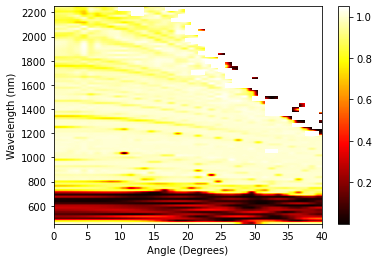

In [63]:
plt.imshow(np.flip(reflectances, axis=1).T, cmap='hot', extent=[0,40,450,2250], aspect='auto')
plt.xlabel('Angle (Degrees)')
plt.ylabel('Wavelength (nm)')
plt.colorbar()

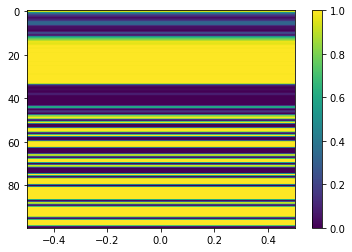

In [69]:
with open('fabricated_structure_reflectance_one_angle.npy', 'rb') as f:
    wfl = np.load(f)
    reflectances = np.load(f)
plt.imshow(np.reshape(np.clip(reflectances, 0,1), (100,1)), aspect='auto')
plt.colorbar()

In [93]:
import numpy as np
from matplotlib.mlab import griddata
import matplotlib.pyplot as plt

xs0 = np.random.random((1000)) * np.pi - np.pi/2
ys0 = np.random.random((1000)) * 3.5
zs0 = np.random.random((1000))

N = 30j
extent = (-np.pi/2,np.pi/2,0,3.5)

xs,ys = np.mgrid[extent[0]:extent[1]:N, extent[2]:extent[3]:N]

resampled = griddata(xs0, ys0, zs0, xs, ys)

plt.imshow(resampled.T, extent=extent)
plt.plot(xs0, ys0, "r.")
plt.plot(xs, ys, "b.")
plt.title("imshow for irregularly spaced data using griddata")
plt.show()

ImportError: cannot import name 'griddata' from 'matplotlib.mlab' (/home/gridsan/wfli/.conda/envs/pmp/lib/python3.8/site-packages/matplotlib/mlab.py)

## Luminosity efficiency function of wavelength

In [154]:
luminosity_data = np.genfromtxt('luminosity_efficiency.csv', delimiter=',')
luminosity_data.shape

(4401, 2)

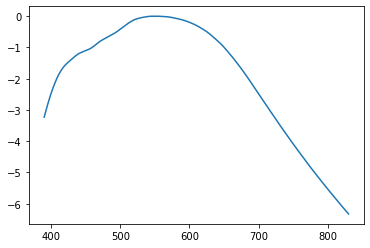

In [155]:
plt.plot(luminosity_data[:, 0], luminosity_data[:, 1])

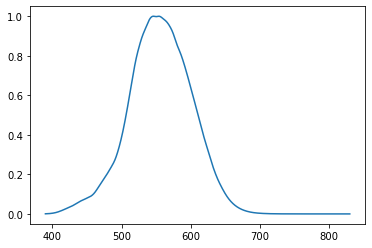

In [156]:
plt.plot(luminosity_data[:, 0], 10**luminosity_data[:, 1])

In [157]:
log10_luminosity = interp1d(luminosity_data[:,0], luminosity_data[:,1])

In [158]:
log10_luminosity(390.11)

array(-3.219941)

In [159]:
def luminosity(lam):
    return 10**log10_luminosity(lam)

## Tungsten emittance function of wavelength and angle at 3000 K

### Normal incidence

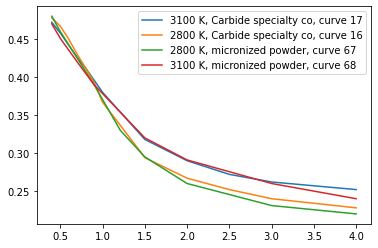

In [167]:
# Use linear interpolation to find emittance at wavelength 3000 K

# curve 17, 3100 K
data_17 = np.array([[0.4, .472], [.5, .458],[.6,.442],[.7,.426],[.8,.412],[.9,.396],[1,.38], [1.5,.318], 
                    [2, .290], [2.5, .272], [3, .262], [4, .252]])
plt.plot(data_17[:, 0], data_17[:, 1], label='3100 K, Carbide specialty co, curve 17')

# curve 16, 2800 K
data_16 = np.array([[0.4, .478], [.5, .467],[.6,.450],[.7,.430],[.8,.412],[.9,.393],[1,.367], [1.42,.306],
                    [1.5,.294], [2, .267], [2.5, .252], [3, .240], [4, .228]])
plt.plot(data_16[:, 0], data_16[:, 1], label='2800 K, Carbide specialty co, curve 16')

# curve 24, 2800 K, tungsten balance of mix
data_24 = np.array([[.25, .41], [.27,.445], [.3,.456], [.32,.457], [.35, .461], [.37,.463], [.40,.461],
                   [.45, .454], [.5, .448], [.55, .443], [.6, .434], [.65, .427], [.7, .419], [.75,.41],
                   [.8, .4], [.9,.373], [1, .367], [1.2, .367], [1.2, .337], [1.32, .328], [1.35, .318],
                   [1.5, .302], [1.6, .292], [1.8, .274], [2.4, .233], [2.6, .224]])
#plt.plot(data_24[:, 0], data_24[:, 1], label='2800 K, mixture, curve 24')

# curve 67, micronized
data_67 = np.array([[0.4, .48], [.5, .46],[.7,.425],[.9,.39],[1.21,.33],
                    [1.5,.295], [2, .260], [3, .231], [4, .22]])
plt.plot(data_67[:, 0], data_67[:, 1], label='2800 K, micronized powder, curve 67')

# curve 68, micronized
data_67 = np.array([[0.4, .47], [.5, .451],[.7,.420],[.9,.39],
                    [1.5,.32], [2, .291], [3, .26], [4, .24]])
plt.plot(data_67[:, 0], data_67[:, 1], label='3100 K, micronized powder, curve 68')

plt.legend()

In [190]:
# we'll interpolate curves 17 and 16 with a cubic and interpolate 3000 K linearly from 2800 and 3100 K

emittance_2800 = interp1d(data_16[:, 0], data_16[:, 1])
emittance_3100 = interp1d(data_17[:, 0], data_17[:, 1])

def emittance_3000(wvl):
    return (2*emittance_2800(wvl) + emittance_3100(wvl))/3

Text(0, 0.5, 'normal spectral emittance')

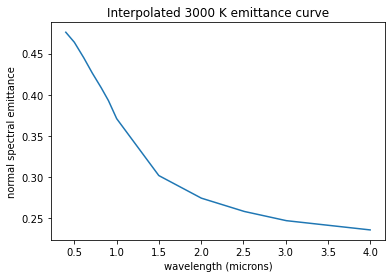

In [191]:
x = np.linspace(.4, 4, 1000)
plt.plot(x, emittance_3000(x))
plt.title('Interpolated 3000 K emittance curve')
plt.xlabel('wavelength (microns)')
plt.ylabel('normal spectral emittance')

### Incidence at an angle

In [ ]:
# Fit emittance/absorptivity to a sum of drude-lorentzian functions

T = 3000

# planck's natural units
c = k = 1
h = 2 * np.pi

emittance = absorptivity = emitttance_3000

def planck_spectral_radiance(wvl):
    # computes power per area per wavelength of a blackbody
    return ((2*h*c**2 / wvl**5)
                            /(np.exp(h*c/(wvl*k*T)) - 1)) 
                        
wavelengths = np.linspace(0.4, 0.8, num=50)
material_absorption = absorptivity(wavelengths)

power_reflectance = 1 - material_absorption